# $$\text{Avaliação Espaço de Estados 1}$$
##### $$\text{Erick N. M. Alves e Robson R. T. Júnior}$$

In [1]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import scienceplots

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
#plt.rcParams['lines.linewidth'] = 2
#plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (10, 8)
colors = ['C0', 'C1', 'C2', 'C4', 'C5']

### $$\text{Definição da função de transferência do sistema:}$$

In [2]:
s = ct.tf('s')

G = ((s+11)/((s**3)+(3*s)+4))

G

TransferFunction(array([ 1, 11]), array([1, 0, 3, 4]))

### $$\text{Representação Canônica Controlável em Espaço de Estados:}$$

In [3]:
sys = ct.tf2ss(G)

n = len(sys.A)
A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[n-1-i][n-1-j] = sys.A[i][j]

B = np.empty((n, 1))
for i in range(n):
    B[n-1-i][0] = sys.B[i][0]

C = np.empty(n)
for i in range(n):
    C[n-1-i] = sys.C[0][i]

D = np.array([0])

ct.ss(A, B, C, D)

StateSpace(array([[ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [-4., -3., -0.]]), array([[0.],
       [0.],
       [1.]]), array([[11.,  1.,  0.]]), array([[0.]]))

### $$\text{Avaliando a controlabilidade:}$$

In [4]:
ctrb = np.hstack([B, A@B, A@A@B])
print(f'Rank da matriz de controlabilidade: {np.linalg.matrix_rank(ctrb)}')

ctrb

Rank da matriz de controlabilidade: 3


array([[ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
       [ 1.,  0., -3.]])

### $$\text{Simulação do sistema em Malha Fechada:}$$

In [5]:
k = np.array([2, 8, 6])

In [6]:
#Sistema:
G = ct.ss(A,B,np.vstack((C, np.identity(n))),np.zeros((n+1, 1)), inputs=['u'], outputs=['y', 'x1', 'x2', 'x3'])

#Gerando o sinal de feedback:
K = []
kxl = []
for i in range(len(k)):
    current_kxl = f'kx{i+1}'
    K.append(ct.tf((k[i]), (1), inputs=f'x{i+1}', outputs=current_kxl))
    kxl.append(current_kxl)
somfb = ct.summing_junction(inputs=kxl, output='feedback')

#Somador que gera o sinal u:
som = ct.summing_junction(inputs=['r', '-feedback'], output='u')

#Interconnect:
componentes = [G, somfb, som]
componentes.extend(K)
L = ct.interconnect(componentes, inputs='r', outputs=['u', 'y', 'x1', 'x2', 'x3'])

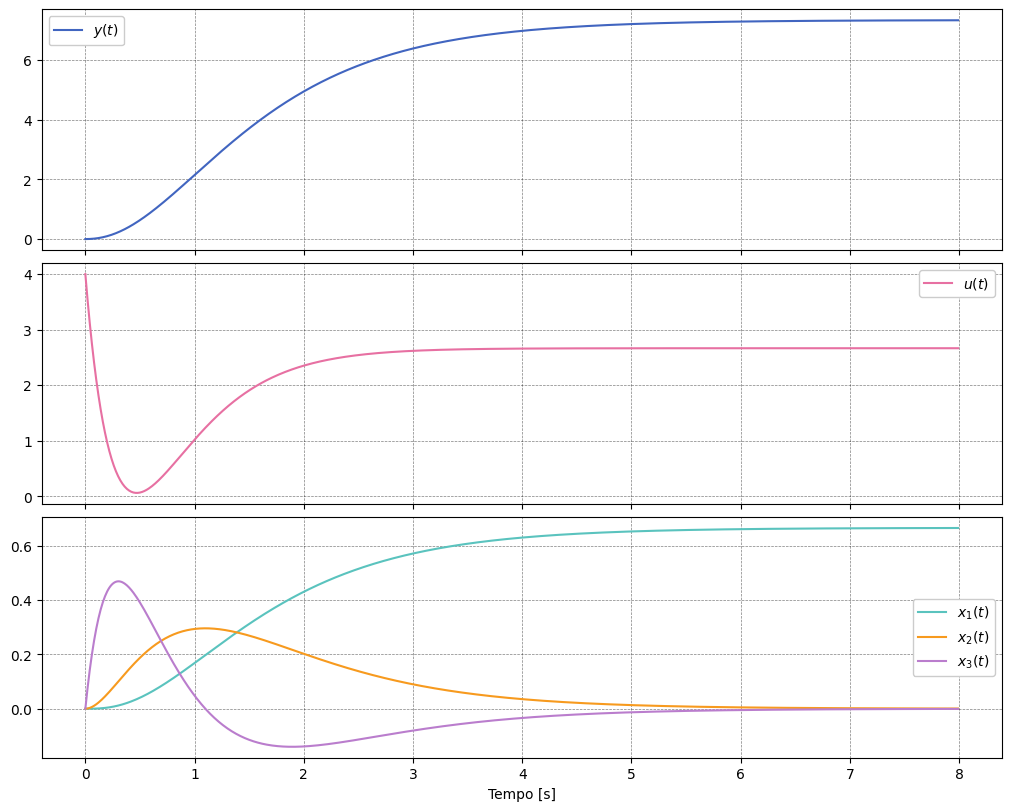

In [7]:
#Vetor de tempo:
t = np.arange(0, 8, 1e-2)

#Vetor de referência:
r = np.ones(t.shape)*4

#Simulação do sistema:
t, sol = ct.forced_response(L, t, r)

#Demultiplex da saída:
u = sol[0]
y = sol[1]
x = sol[2:]

#Plot das curvas:
labels = ['$x_1(t)$', '$x_2(t)$', '$x_3(t)$']
plt.subplots(3, 1, sharex=True, constrained_layout = True)
plt.subplot(3, 1, 1)
plt.plot(t, y, color='C0', label='$y(t)$')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(t, u, color='C1', label='$u(t)$')
plt.legend()
plt.subplot(3, 1, 3)
for i in range(len(x)):
    plt.plot(t, x[i], color=colors[i+2], label=labels[i])
plt.xlabel('Tempo [s]')
plt.legend()
plt.show()

In [8]:
#Conferindo os autovalores da malha fechada:
np.linalg.eigvals(A+np.vstack((np.zeros((n-1, n)), -k)))

array([-1., -2., -3.])